In [9]:
%matplotlib inline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol,\
                        schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd

In [13]:
def initialize(context):
    dji = [
                "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    context.universe = [symbol(s) for s in dji]
    context.history_window = 20
    context.stocks_to_hold = 10 # size of portfolio
    
    # schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())
    
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf

def handle_data(context, data):
    # get history
    hist = data.history(context.universe, "close", context.history_window, "1d")
    
    # create a table of percent returns in order
    perf_table = hist.apply(month_perf).sort_values(ascending=False)
    
    # make buy list of top N stocks
    buy_list = perf_table[:context.stocks_to_hold]
    
    the_rest = perf_table[context.stocks_to_hold:]
    
    # place target buy orders for top N stocks
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold
        
        # place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)
            
    # make sure we are flat the rest
    for stock, perf in the_rest.iteritems():
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)
            
def analyze(context, perf):
    # use pyfolio to generate performance report
    
    returns, position, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)
    
    

Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,9.6%
Cumulative returns,295.3%
Annual volatility,18.2%
Sharpe ratio,0.60
Calmar ratio,0.17
Stability,0.78
Max drawdown,-58.2%


C:\Users\52218\anaconda3\envs\zipline\lib\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.17,2007-10-31,2009-03-09,2013-03-22,1408
1,12.98,2015-07-16,2015-08-25,2016-03-11,172
2,11.09,2004-03-05,2004-08-06,2004-10-06,154
3,10.16,2007-07-19,2007-08-16,2007-10-29,73
4,10.00,2003-01-06,2003-03-11,2003-03-21,55


C:\Users\52218\anaconda3\envs\zipline\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
C:\Users\52218\anaconda3\envs\zipline\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\52218\anaconda3\envs\zipline\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\52218\anaconda3\envs\zipline\lib\site-packages\pandas\plotting

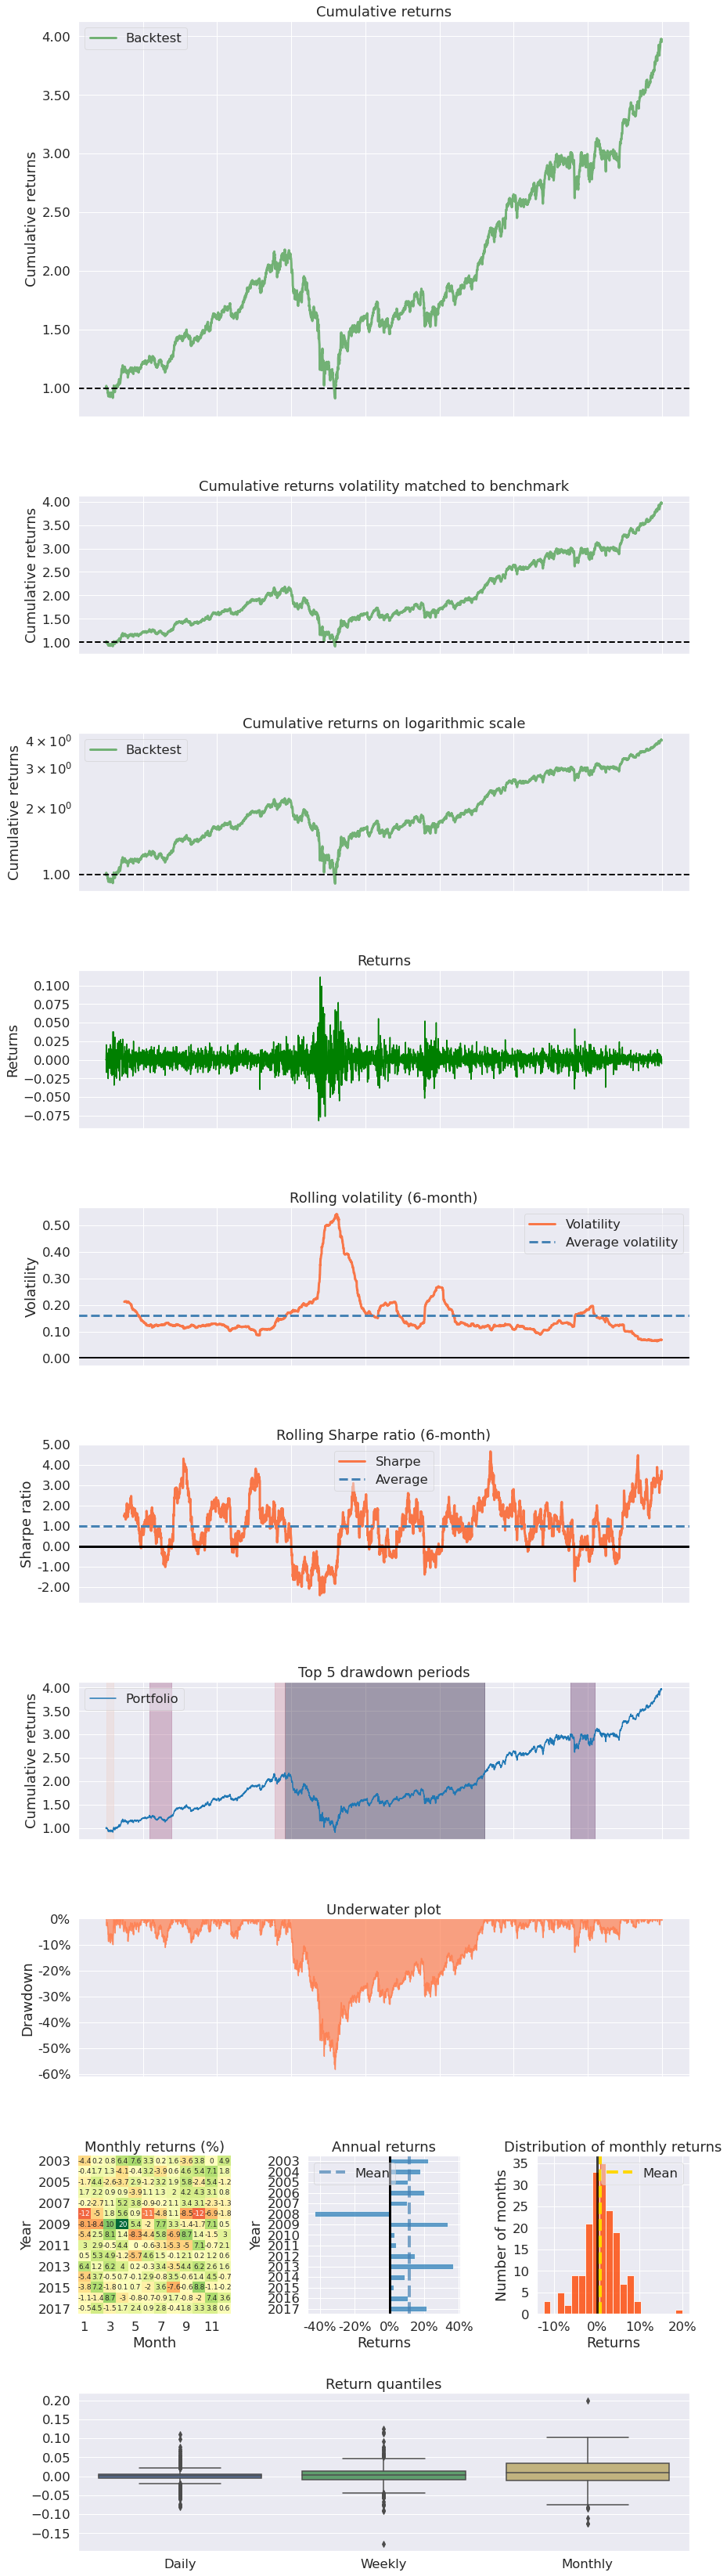

In [14]:
start =  pd.Timestamp(datetime(2003, 1, 1, tzinfo=pytz.UTC))
end =  pd.Timestamp(datetime(2017, 12, 31, tzinfo=pytz.UTC))
result = run_algorithm(
    start=start, 
    end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=10000, 
    data_frequency = 'daily', 
    bundle='quandl' 
)